In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils as ut

In [2]:
# this string must be passed during the execution of gillespie_test.exe
data_dir = '../data/LV/'

In [44]:
params = dict()

# LV parameters
params['process_type'] = 'lv2'
params['rhos'] = [2, 1]
params['chis'] = [1, 2]
params['fs'] = [1.002, 1]
params['M'] = 2000
#print("c = " + str(params['chis'][0] - params['chis'][1]))
print("Mt*s = " + str((params['fs'][0] - params['fs'][1]) * params['M']/params['chis'][1]))

# Gillespie parameters
params['end_cond'] = 'time'
params['max_steps'] = 1000000
params['traj_step'] = 100
params['init_state'] = [100, 300] # Initial condition
params['N_realizations'] = 1

Mt*s = 2.0000000000000018


In [45]:
ut.write_params(params, data_dir, 'param.txt')

In [46]:
traj, labels = ut.read_traj(data_dir+'traj.txt')

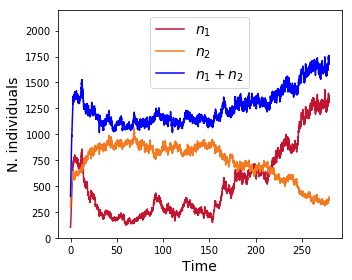

In [47]:
plt.figure(figsize=(5,4))
plt.ylim([0,2200])
plt.xlabel('Time',fontsize=14)
plt.ylabel('N. individuals',fontsize=14)

plt.plot(traj[:,0], traj[:,1], c='#c31432', label=r'$n_1$')
plt.plot(traj[:,0], traj[:,2], c='#f4791f', label=r'$n_2$')
plt.plot(traj[:,0], traj[:,1]+traj[:,2], c='blue', label=r'$n_1+n_2$')

plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('../plots/LV/traj.png', dpi=200, transparent=True)

In [48]:
def slow_mainfold(n1):
    return (params['M'] - params['chis'][0]*n1) / params['chis'][1]

def slow_mainfold_y(y1):
    return 1-y1

In [49]:
def fast_dynamics(n1, n2):
    om = (params['chis'][0]*n1 + params['chis'][1]*n2) / params['M']
    v1 = n1 * params['rhos'][0] * params['fs'][0] * (1 - om)
    v2 = n2 * params['rhos'][1] * params['fs'][0] * (1 - om)
    return v1, v2

def fast_dynamics_y(y1, y2):
    om = y1 + y2
    v1 = y1 * params['rhos'][0] * (1 - om/params['fs'][0])
    v2 = y2 * params['rhos'][1] * (1 - om/params['fs'][0])
    return v1, v2

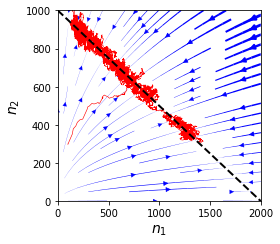

In [50]:
plt.figure(figsize=(4,3.5))

plt.xlabel(r'$n_1$',fontsize=14)
plt.ylabel(r'$n_2$',fontsize=14)

Lx, Ly = 2000, 1000
Y, X = np.mgrid[0:Ly:300j, 0:Lx:300j]
U, V = fast_dynamics(X,Y)
speed = np.sqrt(U*U + V*V)
sp_max=speed.max()
plt.streamplot(X, Y, U, V, density=0.7, cmap=plt.cm.YlOrRd, linewidth=speed/sp_max*3, color='blue')

plt.xlim([0,Lx])
plt.ylim([0,Ly])
plt.plot(traj[:,1], traj[:,2], lw=0.6, c='red')
n1s = np.linspace(1, params['M']/params['chis'][0], 50)
plt.plot(n1s, slow_mainfold(n1s), lw=2, c='black', ls='--')

plt.tight_layout()
plt.savefig('../plots/LV/traj2.png', dpi=200, transparent=True)

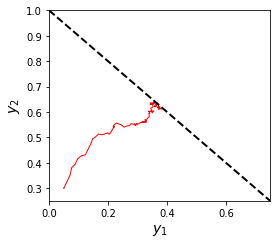

In [73]:
plt.figure(figsize=(4,3.5))

plt.xlabel(r'$y_1$',fontsize=14)
plt.ylabel(r'$y_2$',fontsize=14)

Y, X = np.mgrid[0:1:300j, 0:1:300j]
U, V = fast_dynamics_y(X,Y)
speed = np.sqrt(U*U + V*V)
sp_max=speed.max()
#plt.streamplot(X, Y, U, V, density=0.8, cmap=plt.cm.YlOrRd, linewidth=speed/sp_max*5, color='blue')

plt.xlim([0,0.75])
plt.ylim([0.25,1])
y1_traj = traj[:50000,1] * params['chis'][0] / params['M']
y2_traj = traj[:50000,2] * params['chis'][1] / params['M']
fast_ind = 100
plt.plot(y1_traj[:fast_ind], y2_traj[:fast_ind], lw=1, c='red')
#plt.plot(y1_traj, y2_traj, lw=0.6, c='red')
y1s = np.linspace(0, 1, 50)
plt.plot(y1s, slow_mainfold_y(y1s), lw=2, c='black', ls='--')

plt.tight_layout()
plt.savefig('../plots/LV/traj2_y.svg', dpi=200, transparent=True)

In [31]:
speed.max()

2129.266957846709

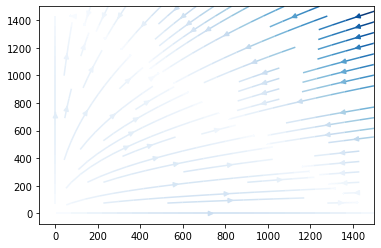

In [21]:
Lx, Ly = params['M']/params['chis'][0], params['M']/params['chis'][1]
Y, X = np.mgrid[0:Ly:300j, 0:Lx:300j]
U, V = fast_dynamics(X,Y)
speed = np.sqrt(U*U + V*V)
plt.streamplot(X, Y, U, V, density=0.7, color=speed, cmap=plt.cm.Blues)

In [44]:
def drift_x(x, x2, xN, x2N, params):
    auxR = (1 - params['alpha']*(1 + x/params['M']))*(params['betas'][0] - params['betas'][1])
    auxRx = auxR * (x - x2)
    auxD = (1 + params['alpha']*(1 + x/params['M']))*(params['betas'][0] - params['betas'][1])
    auxDx = auxD * (xN - x2N)
    return auxRx - auxDx
    
def drift_N(N, N2, n, nN, params):
    auxn = (params['betas'][0] - params['betas'][1]) * (1 - params['alpha'])* n 
    auxNn = -params['alpha']/params['M']*(params['betas'][0] - params['betas'][1])* nN 
    auxN = params['betas'][1] * (1 - params['alpha']) * N
    auxN2 = -params['betas'][1] * params['alpha']/params['M'] * N2
    return auxn + auxN + auxNn + auxN2

def integrate(obs, init_x, init_N):
    traj_N, traj_x = [init_N], [init_x]
    av_n = obs[0]
    av_n2 = obs[1]
    av_N = obs[2]
    av_N2 = obs[3]
    av_nN = obs[4]
    av_x = obs[5]
    av_x2 = obs[6]
    av_xdN = obs[7]
    av_x2dN = obs[8]
    av_t = obs[9]
    step=1
    while step < len(av_t):
        ax = drift_x(av_x[step], av_x2[step], av_xdN[step], av_x2dN[step], params)
        aN = drift_N(av_N[step], av_N2[step], av_n[step], av_nN[step], params)
        traj_N.append(traj_N[-1] + aN * (av_t[step]-av_t[step-1]))
        traj_x.append(traj_x[-1] + ax * (av_t[step]-av_t[step-1]))
        step+=1
    return np.array(traj_x), np.array(traj_N)

In [45]:
av_traj, labels = ut.read_traj(data_dir+'obs.txt')
av_ts = av_traj[1:-2,0]
av_ns = av_traj[1:-2,2]
av_n2s = av_traj[1:-2,3]
av_Ns = av_traj[1:-2,4]
av_N2s = av_traj[1:-2,5]
av_nNs = av_traj[1:-2,6]
av_xs = av_traj[1:-2,7]
av_x2s = av_traj[1:-2,8]
av_xdNs = av_traj[1:-2,9]
av_x2dNs = av_traj[1:-2,10]
obs = [av_ns, av_n2s, av_Ns, av_N2s, av_nNs, av_xs, av_x2s, av_xdNs, av_x2dNs, av_ts]

traj_x, traj_N = integrate(obs, av_xs[0], av_Ns[0])

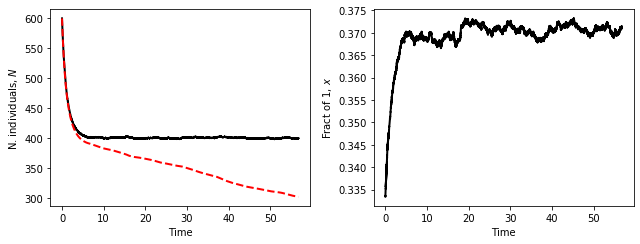

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,3.5))

ax1.set_xlabel('Time')
ax1.set_ylabel('N. individuals, $N$')
ax1.plot(av_ts, av_Ns, c='black',lw=2)
#std = np.sqrt(m2_Ns - av_Ns**2)
#ax1.fill_between(av_ts, av_Ns - std, av_Ns + std, alpha=0.6)
ax1.plot(av_ts, traj_N, c='red', ls='--', lw=2)
#ax1.plot(np.linspace(0,fin_time,len(traj_N)), traj_N + np.sqrt(traj_varN)/2, c='red', ls='--', lw=2)


ax2.set_xlabel('Time')
ax2.set_ylabel('Fract of 1, $x$')
ax2.plot(av_ts, av_xs, c='black', lw=2)
#std = np.sqrt(m2_xs - av_xs**2)
#ax2.fill_between(av_ts, av_xs - std, av_xs + std, alpha=0.6)
#ax2.plot(np.linspace(0,fin_time,len(traj_x)), traj_x, c='red', ls='--',lw=2)
#ax2.plot(np.linspace(0,fin_time,len(traj_x)), traj_x + np.sqrt(traj_varx)/2, c='red', ls='--', lw=2)


plt.tight_layout()

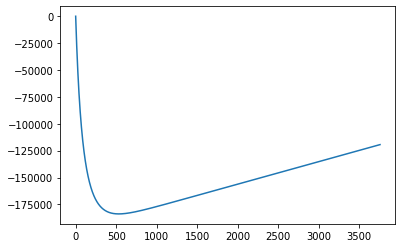

In [264]:
av_n1s = av_traj[1:,2]
av_n2s = av_traj[1:,3]

In [204]:
def drift_x_large_N(x, N, params):
    auxR = (1 - params['alpha']*(1 + N/params['M']))
    auxD = (1 + params['alpha']*(1 + N/params['M']))
    return -2 * x * (1-x) * (params['betas'][0] - params['betas'][1]) / params['M']/(1/params['alpha']-1)

def drift_x_large_N2(x, N, params):
    bm = x * params['betas'][0] + (1-x) * params['betas'][1]
    auxb = -(params['betas'][0] - params['betas'][1]) * params['betas'][0] * params['betas'][1]
    return x * (1-x) * auxb / bm / params['M']/(1/params['alpha']-1)

def drift_N_large_N(x, N, params):
    return 0

In [229]:
step_Neq = 12000
print(av_ts[step_Neq])
av_ts2 = av_ts[step_Neq:]
av_Ns2 = av_Ns[step_Neq:]
m2_Ns2 = m2_Ns[step_Neq:]
av_xs2 = av_xs[step_Neq:]
m2_xs2 = m2_xs[step_Neq:]

traj_x, traj_N = integrate(0.01, drift_x_large_N, drift_N_large_N, av_xs2[0], av_Ns2[0], fin_time)
traj_x2, traj_N2 = integrate(0.01, drift_x_large_N2, drift_N_large_N, av_xs2[0], av_Ns2[0], fin_time)
traj_x3, traj_N3 = integrate(0.01, drift_x, drift_N, av_xs2[0], av_Ns2[0], fin_time)

7.52321


TypeError: integrate() missing 4 required positional arguments: 'init_N', 'init_varx', 'init_varN', and 'max_time'

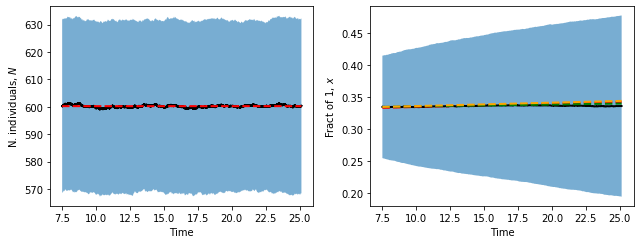

In [230]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,3.5))

ax1.set_xlabel('Time')
ax1.set_ylabel('N. individuals, $N$')
ax1.plot(av_ts2, av_Ns2, c='black',lw=2)
std = np.sqrt(m2_Ns2 - av_Ns2**2)
ax1.fill_between(av_ts2, av_Ns2 - std, av_Ns2 + std, alpha=0.6)
ax1.plot(np.linspace(av_ts2[0],fin_time,len(traj_N)), traj_N2, c='red', ls='--', lw=2)


ax2.set_xlabel('Time')
ax2.set_ylabel('Fract of 1, $x$')
ax2.plot(av_ts2, av_xs2, c='black', lw=2)
std = np.sqrt(m2_xs2 - av_xs2**2)
ax2.fill_between(av_ts2, av_xs2 - std, av_xs2 + std, alpha=0.6)
ax2.plot(np.linspace(av_ts2[0],fin_time,len(traj_x)), traj_x, c='red', ls='--',lw=2)
ax2.plot(np.linspace(av_ts2[0],fin_time,len(traj_x)), traj_x2, c='green', ls='--',lw=2)
ax2.plot(np.linspace(av_ts2[0],fin_time,len(traj_x)), traj_x3, c='orange', ls='--',lw=2)


plt.tight_layout()

In [207]:
traj_N[step_Neq:]

array([], dtype=float64)

In [23]:
def N_weights(N, a, M, scale):
    aux1 = -2*N + 4*M/a*np.log(1+a+a*N/M)
    aux2 = -np.log(N/M) - np.log(1+a+a*N/M)
    return np.exp((aux1+aux2)-scale)

def N_weights_appr(N, a, M, scale):
    aux1 = -2*N + 4*M/a*np.log(1+a+a*N/M)
    return np.exp(aux1-scale)

def pN_approx(y,a,M):
    aux1 = -2*y*M + 4*M/a*np.log(1+a+a*y)
    auxZ = -2*M*(1/a-a) + np.log(np.pi*M/a)/2
    return np.exp(aux1-auxZ)

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


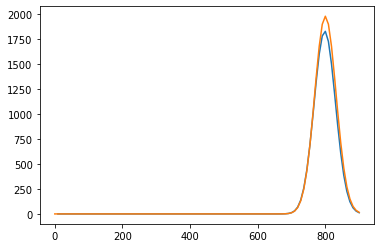

In [31]:
Ns = np.linspace(0,900,100)
plt.plot(Ns, N_weights(Ns, params['alpha'], params['M'],1163))
plt.plot(Ns, N_weights_appr(Ns, params['alpha'], params['M'],1165))

In [32]:
fin_states, labels = ut.read_traj(data_dir+'final_state.txt')
N_final = fin_states[:,1] + fin_states[:,2]

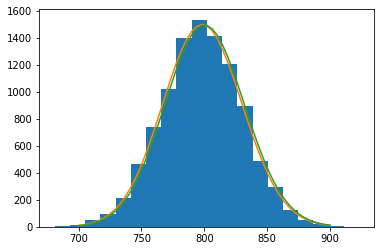

In [102]:
h = plt.hist(N_final, bins=20)
plt.plot(Ns, N_weights(Ns, params['alpha'], params['M'],1163.2))
plt.plot(Ns, N_weights_appr(Ns, params['alpha'], params['M'],1165.28))

In [71]:
traj_x, traj_N = integrate(0.01, drift_x, drift_N, 0.5, 400, 10)